In [53]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
# import resource

In [3]:
def find_smoothness(X, Y, lambda_):
    # finds smallest L to guarantee L-smoothness of the Logistic Ridge Regression, given data X, Y
    # we have found it analytically as L_guarantee = (1/(4N)) * sum y_i^2 ||x_i||^2 - 2*lambda
    
    N, d = X.shape
    assert Y.shape == (N,1)
    
    Z = (np.linalg.norm(Y * X, axis=1)**2) # (N,)
    L = (1/(4*N)) * np.sum(Z) + 2*lambda_
    
    return L

def find_smallest_smoothness(X, Y, lambda_):
    # finds smallest L to guarantee L-smoothness of the Logistic Ridge Regression, given data X, Y
    # we have found it analytically as L_guarantee = (1/(4N)) * sum y_i^2 ||x_i||^2 - 2*lambda
    
    N, d = X.shape
    assert Y.shape == (N,1)
    
    Z = (np.linalg.norm(Y * X, axis=1)**2) # (N,)
    L = (1/4) * np.min(Z) + 2*lambda_
    
    return L

def find_median_smoothness(X, Y, lambda_):
    # finds smallest L to guarantee L-smoothness of the Logistic Ridge Regression, given data X, Y
    # we have found it analytically as L_guarantee = (1/(4N)) * sum y_i^2 ||x_i||^2 - 2*lambda
    
    N, d = X.shape
    assert Y.shape == (N,1)
    
    Z = (np.linalg.norm(Y * X, axis=1)**2) # (N,)
    L = (1/4) * np.median(Z) + 2*lambda_
    
    return L

def find_mean_smoothness(X, Y, lambda_):
    # finds smallest L to guarantee L-smoothness of the Logistic Ridge Regression, given data X, Y
    # we have found it analytically as L_guarantee = (1/(4N)) * sum y_i^2 ||x_i||^2 - 2*lambda
    
    N, d = X.shape
    assert Y.shape == (N,1)
    
    Z = (np.linalg.norm(Y * X, axis=1)**2) # (N,)
    L = (1/4) * np.mean(Z) + 2*lambda_
    
    return L

In [4]:
## Preprocessing of data
# Load data here:

N_sites = 2921
N_cols = 327
dghg = 15
Nghg = N_sites * N_cols
ghgdata = np.zeros((dghg+1, Nghg))

pathprefix = "./Data/ghg_data/ghg_data/ghg.gid.site"
for i in range(N_sites):
    filename = pathprefix + str(i + 1).zfill(4) + ".dat"
    subdata = np.genfromtxt(filename, delimiter=" ")
    ghgdata[:,i*N_cols:(i+1)*N_cols] = subdata

ghgdata = ghgdata.T

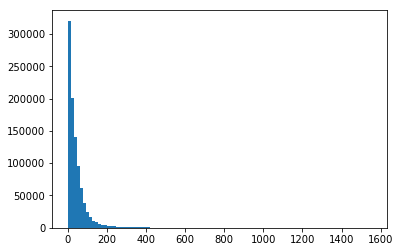

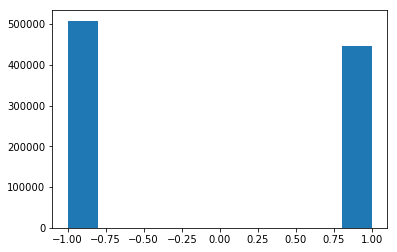

In [5]:
X = ghgdata[:, 0:dghg]
Y = ghgdata[:, [dghg]]
plt.figure(1)
_ = plt.hist(Y, bins=100)

# threshold Y to binary
threshold = 30
mask = Y < threshold
Y[mask] = -1
Y[~mask] = 1
plt.figure(2)
_ = plt.hist(Y)

In [6]:
# Split train and test data here: (X_train, Y_train, X_test, Y_test)

N_train = math.floor(Nghg*0.75)
N_test = math.floor(Nghg*0.25) + 1

N_train = 1000
N_test = 1000

# train_idx = np.random.choice(Nghg, size=N_train, replace=False)
train_idx = np.arange(N_train)
X_train = X[train_idx, :]
Y_train = Y[train_idx]

# test_idx_bool = ~np.isin(np.arange(Nghg), train_idx)
test_idx = np.arange(N_train, N_train + N_test)
X_test = X[test_idx, :]
Y_test = Y[test_idx]

#### Logistic Ridge regression
$$ f(x) = \frac{1}{N}\sum_{i\in[N]} f_i(x) + \lambda\lVert w \rVert_2^2 $$
has the gradient: 
$$ \nabla f(x) = \frac{1}{N}\sum_{i\in[N]} \nabla f_i(x) + 2\lambda w, $$
$$ \nabla f_i(x) = -y_i x_i \frac{e^{-y_ix_i^T w}}{1 + e^{-y_ix_i^T w}} = -y_i x_i \frac{1}{1 + e^{y_i x_i^T w}}.$$
We use the latter form for computing gradients, since it has better numerical stability.

$$ \hat{g}(w) =  \nabla f_i(w) + 2 \lambda w  $$
$$ (\alpha /N ) \sum \nabla f_i(w) + 2 \lambda w $$


$$ \sum_{i=1}^N  y_i^2 x_i x_i^T  $$

$$ X = \begin{bmatrix} y_1 x_1^T \\ \vdots \\ y_N x_N^T\end{bmatrix} $$ 

$$  X^T X = \sum y_i^2 x_i x_i^T  $$

$$ L I \geq (1/4N) X^T X + 2\lambda $$

In [7]:
## Logistic ridge regression with different optimizers
# cost function and gradient calculation

def cost(x, y, w, lambda_ = 0.01):
    N, d = x.shape
    value = np.sum(np.log(1 + np.exp(- y*x @ w)))
    norm_w = np.linalg.norm(w)
    c = lambda_ * norm_w ** 2
    return value/N + c 

def function_gradient(X, Y, w, lambda_):
#     set_trace()
    N, d = X.shape
    assert Y.shape == (N,1)
    assert w.shape == (d,1)
    output = np.zeros((N,1))
    YX = Y * X # (N,d)
    YXw = YX @ w # (N,1)
    exp_vec = 1/(1 + np.exp(YXw)) # (N,1)
    grad_array = -YX * exp_vec # (N,d)
    output = np.sum(grad_array, axis=0) # (1,d)
    output = (1/N) * output.reshape(d,1) + 2 * lambda_ * w # (d,1)
    return output # (d,1)

In [27]:
# ---------------------- Complete the blank definitions: --------------------------------------

def solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer = "GD", mem=False, return_cost=False):
    if (optimizer == "GD"):
        cost_ = np.zeros(num_iters)
        for i in range(num_iters):
#             set_trace()
            g = function_gradient(x, y, w, lambda_) # compute the exact gradient wrt w, given x and y
            w = w - alpha * g # GD update
            
            if return_cost:
                cost_[i] = cost(X_test, Y_test, w, lambda_)
            
            if (i%10==0) and (mem):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for GD (mb):", (usage[2]*resource.getpagesize())/1000000.0)
                        
            if (np.linalg.norm(g) <= epsilon):
                print("GD: Stop on condition fulfilled! Number of iterations: ", i+1, "/", num_iters)
                break
#         print("GD: Number of iterations: ", num_iters, "/", num_iters)
#         print("GD: final norm: ", np.linalg.norm(g))
                
    elif (optimizer == "SGD"):
        cost_ = np.zeros(num_iters)
        N, d = x.shape
        assert y.shape == (N,1)
        for i in range(num_iters):
            i_ = int(N*np.random.rand(1))
            x_ = x[[i_], :]
            y_ = y[[i_], :]
            
            g = function_gradient(x_, y_, w, lambda_) # compute gradient
            w = w - alpha * g # GD update 
            
            if return_cost:
                cost_[i] = cost(X_test, Y_test, w, lambda_)
                
    elif (optimizer == "SVRG"):
        N, d = x.shape
        assert y.shape == (N,1)
        
        T = 100 # epoch length
        K = math.floor(num_iters/T) # number of epochs, given number of iterations
        
        if K == 0:
            # only run for one epoch consisting of num_iters iterations
            K = 1
            T = num_iters
        
        cost_ = np.zeros(T*K)
        
        for k in range(K):
            yx = y * x # (N, d)
            yxw = yx @ w # (N, 1)
            
            assert yx.shape == (N, d)
            assert yxw.shape == (N, 1)
            
            # G_ is equal to using function_gradient, but we need G_vec, so we compute it manually here
            exp_vec = 1/(1 + np.exp(yxw)) # (N, 1)
            
            G_vec = (-yx * exp_vec).reshape(d, N) + 2*lambda_*w # (d, N)
                                    
            G_ = (1/N) * np.sum(G_vec, axis=1, keepdims=1) # (d, 1)
            
            if (np.linalg.norm(G_) <= epsilon): # check the average gradient
                print("SVRG: Stop on condition fulfilled! Number of iterations: ", k*t, "/", num_iters)
                break
            
            assert G_vec.shape == (d, N)
            assert G_.shape == (d, 1)
            
            for t in range(T):
                i_ = int(N*np.random.rand(1))
                x_ = x[[i_], :] # (1, d)
                y_ = y[[i_], :] # (1, 1)
                g = function_gradient(x_, y_, w, lambda_) # (d, 1)
                assert g.shape == (d,1)
                assert G_vec[:, [i_]].shape == (d,1)
                assert G_.shape == (d,1)
                w = w - alpha*(g - G_vec[:, [i_]] + G_)
                
                if return_cost:
                    cost_[t + k*T] = cost(X_test, Y_test, w, lambda_)
#         if K > 0:
#             print("SVRG: final norm: ", np.linalg.norm(g))
            
    elif (optimizer == "SAG"):
        N, d = x.shape
        assert y.shape == (N,1)
        
        # compute initial gradient estimates for all datapoints
        yx = y * x # (N, d)
        yxw = yx @ w # (N, 1)
        exp_vec = 1/(1 + np.exp(yxw)) # (N, 1)
        G_vec = (-yx * exp_vec).reshape(d, N) + 2 * lambda_ * w # (d, N)
        
        cost_ = np.zeros(num_iters)
        for k in range(num_iters):
            #set_trace()
            i_ = int(N*np.random.rand(1))
            x_ = x[[i_], :] # (1, d)
            y_ = y[[i_], :] # (1, 1)
            g = function_gradient(x_, y_, w, lambda_) # (d, 1)
            G_vec[:, [i_]] = g # (d, N)
            w = w - (alpha/N) * np.sum(G_vec, axis=1, keepdims=1) # (d, 1)
            if return_cost:
                cost_[k] = cost(X_test, Y_test, w, lambda_)
                
            if (np.linalg.norm(g) <= epsilon):
                    print("Stop on condition fulfilled! Number of iterations: ", k, "/", num_iters)
                    break
#         print("final norm: ", np.linalg.norm(g))
    if return_cost:
        return w, cost_
    else:
        return w

### Setting the constant stepsize

In [14]:
## Define solvers: GD, SGD, SVRG and SAG. 
# Setting the values here:

lambda_ = 100 # change the value 1e-6 is good for full matrices
epsilon = 0.000001 # change the value

In [63]:
y = Y_train
x = X_train
print(x.shape)
print(y.shape)
N, D = x.shape
w = np.random.rand(D,1)*0.1  # Initialization of w

# smoothness and convexity
L = find_smoothness(x, y, lambda_)
print("L", L)
alpha = 1/(16*L)

eigs, _ = np.linalg.eig((y * x).T @ (y * x))
eig_max = np.max(eigs)
L_eig = eig_max/4/N
print("eigmax", eig_max/4/N)
print("alpha: ", alpha)
print(1/L)
print(1/L_eig)

(1000, 15)
(1000, 1)
L 5564.365387800136
eigmax 5285.216850825762
alpha:  1.1232188334905392e-05
0.00017971501335848627
0.0001892069953276865


In [17]:
#-------------------- GD Solver -----------------------
print(alpha)
num_iters = 10000 # change the value
start = time.time()
gd = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer = "GD", mem=False)
end = time.time()
print("Weights of GD after convergence: \n", gd.flatten())
cost_value = cost(X_test, Y_test, gd, lambda_) 
print("Cost of GD after convergence: ", cost_value)

print("Training time for GD: ", end-start)

0.00017971501335848627
GD: Stop on condition fulfilled! Number of iterations:  480 / 10000
Weights of GD after convergence: 
 [-2.24221603e-06 -4.83258504e-05  2.11638410e-06  3.12940150e-06
 -3.25129641e-06  1.37425758e-07  7.80331835e-06  2.15384289e-04
 -1.15940251e-04  3.60719354e-05 -2.57896043e-04  3.64150470e-03
  1.03339085e-05  1.53444135e-02  1.70927269e-05]
Cost of GD after convergence:  [[0.33051342]]
Training time for GD:  0.053862571716308594


In [18]:
#-------------------- SGD Solver -----------------------
num_iters = 10 # change the value
start = time.time()
sgd = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer = "SGD", mem=False)
end = time.time()
print("Weights of SGD after convergence: \n", sgd.flatten())

cost_value = cost(X_test, Y_test, sgd, lambda_)  # Calculate the cost value
print("Cost of SGD after convergence: ", cost_value)

print("Training time for SGD: ", end-start)

Weights of SGD after convergence: 
 [0.0620571  0.02379093 0.05105552 0.06679161 0.02018811 0.03756941
 0.06743706 0.0087791  0.03969027 0.03683271 0.00508708 0.0294709
 0.0325689  0.01199695 0.03137691]
Cost of SGD after convergence:  [[2.67715802]]
Training time for SGD:  0.0009725093841552734


In [19]:
#-------------------- SVRG Solver -----------------------
num_iters = 10000 # change the value
start = time.time()
svrg = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer="SVRG", mem=False)
end = time.time()
print("\nWeights of SVRG after convergence: \n", svrg.flatten())

cost_value = cost(X_test, Y_test, svrg, lambda_)
print("Cost of SVRG after convergence: ", cost_value[0,0])
print("Training time for SVRG: ", end-start)


Weights of SVRG after convergence: 
 [-0.00120042  0.0006137  -0.0008614  -0.00081234 -0.00326973  0.00277864
  0.00041477  0.00187607 -0.0008886   0.00495382  0.00035762  0.00573062
 -0.0032673   0.01014916 -0.00031914]
Cost of SVRG after convergence:  0.36704037659438427
Training time for SVRG:  0.37799572944641113


In [20]:
#-------------------- SAG Solver -----------------------
num_iters = 10000 # change the value
start = time.time()
sag = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer="SAG", mem=False)
end = time.time()
print("Weights of SAG after convergence: \n", sag.flatten())

cost_value = cost(X_test, Y_test, sag, lambda_)
print("Cost of SAG after convergence: ", cost_value[0,0])
print("Training time for SAG: ", end-start)

Weights of SAG after convergence: 
 [0.00184035 0.00065957 0.00153283 0.0019447  0.00064823 0.00099513
 0.00248286 0.00036292 0.00113057 0.00107565 0.00014579 0.0014748
 0.00065424 0.01536822 0.00105253]
Cost of SAG after convergence:  0.334526652151493
Training time for SAG:  0.5724947452545166


In [ ]:
## Executing the iterations and plot the cost function here:
I_max = 100
ti= np.zeros((I_max,4))
cost_= np.zeros((I_max,4))
w = np.random.rand(D,1)*0.01
for i in range(I_max):
    print("......",i,".......")
    #--------------GD-------------------
    start = time.time()
    gd = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="GD", mem=False)
    end = time.time()

    cost_[i,0] = cost(X_test, Y_test, gd, lambda_)

    ti[i,0] = end-start

    #---------------SGD------------------
    start = time.time()
    sgd = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="SGD", mem=False)
    end = time.time()

    cost_[i,1] = cost(X_test, Y_test, sgd, lambda_)

    ti[i,1] = end-start
    
    #---------------SVRG----------------
    start = time.time()
    svrg = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="SVRG", mem=False)
    end = time.time()

    cost_[i,2] = cost(X_test, Y_test, svrg, lambda_)

    ti[i,2] = end-start
    
    #---------------SAG------------------
    start = time.time()
    sag = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="SAG", mem=False)
    end = time.time()

    cost_[i,3] = cost(X_test, Y_test, sag, lambda_)

    ti[i,3] = end-start
    
    #------------------------------------
    
    ## Pl the results:
    

l0 = plt.plot(cost_[:,0],color="C3")
l1 = plt.plot(cost_[:,1],color="C2")
l2 = plt.plot(cost_[:,2],color="C1")
l3 = plt.plot(cost_[:,3],color="C0")
# complete other plots here: 


plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()

l0 = plt.plot(ti[:,0],color="C3")
l1 = plt.plot(ti[:,1],color="C2")
l2 = plt.plot(ti[:,2],color="C1")
l3 = plt.plot(ti[:,3],color="C0")
# complete other plots here:

plt.xlabel("Number of Iteration")
plt.ylabel("Time (sec)")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()

...... 0 .......


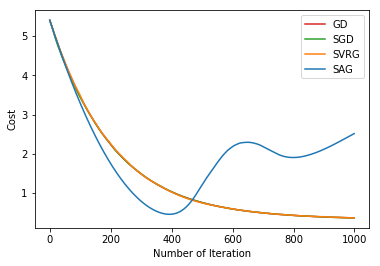

In [51]:
## Executing the iterations and plot the cost function here:
n_sims = 1
I_max = 1000
ti= np.zeros((I_max,4))
cost_= np.zeros((I_max,4))
for n in range(n_sims):
    w = np.random.rand(D,1)*0.1
    
    print("......",n,".......")
    #--------------GD-------------------
    gd, gd_cost  = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="GD", mem=False, return_cost=True)

    cost_[:,0] += gd_cost/n_sims

    #---------------SGD------------------
    sgd, sgd_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SGD", mem=False, return_cost=True)

    cost_[:,1] += sgd_cost/n_sims
    
    #---------------SVRG----------------
    svrg, svrg_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SVRG", mem=False, return_cost=True)

    cost_[:,2] += svrg_cost/n_sims
    
    #---------------SAG------------------
    sag, sag_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SAG", mem=False, return_cost=True)
    
    cost_[:,3] += sag_cost/n_sims
    
    #------------------------------------
## PLOTs
l0 = plt.plot(cost_[:,0],color="C3")
l1 = plt.plot(cost_[:,1],color="C2")
l2 = plt.plot(cost_[:,2],color="C1")
l3 = plt.plot(cost_[:,3],color="C0")
# complete other plots here: 

plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()

(0, 1)

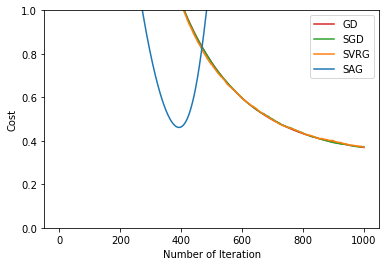

In [52]:
## PLOTs
l0 = plt.plot(cost_[:,0],color="C3")
l1 = plt.plot(cost_[:,1],color="C2")
l2 = plt.plot(cost_[:,2],color="C1")
l3 = plt.plot(cost_[:,3],color="C0")
# complete other plots here: 

plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])

plt.ylim(0, 1)

In [ ]:
## Tunning the hyper-paramter here:

In [ ]:
## Comparing different optimizers here: 